# Gathering Insight from Kickstarter Data: Machine Learning

_A project by Team Apple (Data Mining & Machine Learning, HEC Lausanne, Fall 2019)_

**Contents**

1. [Imports & installations](#imports)
2. [Machine learning models](#ml)
    1. [Logistic regression](#logr)
    2. [k-nearest neighbors](#knn)
    3. [Decision tree & random forest](#dtrf)
    4. [Neural network](#nn)
    5. [Linear regression](#linr)
3. [Conclusion](#conclusion)

## 1. Imports & installations<a name="imports"></a>

In [1]:
!pip install keras

In [2]:
!pip install --upgrade tensorflow==1.14.0

Requirement already up-to-date: tensorflow==1.14.0 in c:\programdata\anaconda3\lib\site-packages (1.14.0)


In [1]:
# loading the cleaned dataset
from cleaning import df

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

Using TensorFlow backend.


## 2. Machine learning models<a name="ml"></a>

### Quick reminder

* We are trying to find out which **machine learning model** (if any at all), and which **features**, can most accurately predict the success or failure of a project.
* The predicted classes are either **1** (= successful) or **0** (= failed).
* The base rate of the majority class (failed) is **63.66%**.

We thought it would be interesting to try all the classification models seen during the course (in the same order) and pit them against each other to see which one would perform best with our dataset.

Of all available features, only the following were considered:

* `usd_goal_real`: the goal set by the project creator (in USD)
* `elapsed_time`: the time that passed between the launch date and the deadline 
* `category`: the specific category chosen for the project
* `main_category`: the main category chosen for the project
* `country`: where the project originates from

The reason for this is that the project creator has some level of control over them. Other features, such as `backers` or `usd_pledged_real` are rather an indicator whether a project is successful
The same methodology was applied for each model:
1. Test e


 for each model, always try to explore each feature on its own to see how well it's doing

Numeric features are normalized between 0 and 1 in order to have a better basis for comparison.

In [2]:
mm = MinMaxScaler()
std = StandardScaler()

goal_mm = pd.DataFrame(mm.fit_transform(df["usd_goal_real"].to_numpy().reshape(-1, 1)))
goal_std = pd.DataFrame(std.fit_transform(df["usd_goal_real"].to_numpy().reshape(-1, 1)))
time_mm = pd.DataFrame(mm.fit_transform(pd.to_numeric(df["elapsed_time"]).to_numpy().reshape(-1, 1)))
time_std = pd.DataFrame(std.fit_transform(pd.to_numeric(df["elapsed_time"]).to_numpy().reshape(-1, 1)))

We are setting the random state to an arbitrarily chosen number to enable comparison between models and their parameters.

In [38]:
RSEED = 42

X = pd.DataFrame()
#X = df[["usd_goal_real"]]
#X = pd.concat((X, df[["usd_goal_real"]], pd.to_numeric(df["elapsed_time"])), axis=1)
X = pd.concat((X, goal_std), axis=1)
y = df["state"]


le = LabelEncoder()
for col in ["category", "main_category"]:
    encoded = pd.DataFrame(le.fit_transform(df[col]), columns=[col])
    X = pd.concat((X, encoded), axis=1)

"""

    
one_hot = OneHotEncoder()
cat_to_onehot = pd.DataFrame(one_hot.fit_transform(df[["category", "main_category"]]).toarray())
X = pd.concat((X, cat_to_onehot), axis=1)



"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)
X_train.head()

,0,category,main_category
235186,-0.029525,8,13
109545,-0.039363,69,6
224633,0.092953,136,8
124354,-0.036852,52,5
351930,-0.039068,106,8


### A. Logistic regression<a name="logr"></a>

Before even settling on a set of features that we deemed viable and logical to give as input to our models, the first thing we did was to run logistic regression on the goal and the amount of money pledged to see how accurate they were at predicting the success or failure of a project. If the dataset is coherent, this number should be very close to 100% and indeed, we reached near-perfection.

Moving beyond the obvious, we started including other features such as the category and the country. We did not include the amount pledged as a feature, since this is not a variable that the project creator has direct control over.

Since they are categorical data, we need to use either label encoding (LE) or one-hot encoding (OH) so that the regression model can work with it.

withh mm, convergence errors

we first started to look at the classification report for recall and precision, but noticed that generally speaking, as accuracy increases, so does precision/recall. For log regression, the recall is pretty good for "failed" (around 86%), but pretty bad for successful (around 38%).

first use LR (first method seen in class) to explore how different features affect accuracy.

After having played with the different features and training/testing multiple times, it turns out the specific category is the one that brings the highest marginal increase in accuracy. (but since lot of values, slow runtime --> possible to pick only maincat, but not as good accuracy) We also find that OH performs much better than LE.

It turns out simply picking the cat-main cat pair is what's more relevant to increase accuracy.

one must normalize time to increase accuracy

not only do goal and time not bring more accuracy (more or less = to base rate, they actually decrease it when used with more relevant features.

decide do keep only category and main category, which seem to work well together. Adding country gives similar scores, so no need to include it (to speed up runtime).


In [32]:
LR = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=1000, random_state=RSEED)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6810950245799795

In [ ]:
# classification_report(y_test, LR.predict(X_test), output_dict=True)

### B. k-NN<a name="knn"></a>

k-NN not supposed to work that well with categorical data, but here performs as well as the other models. Reason?

We thought we might also give k-NN a try. However, k-NN is known to be more inefficient as the number of features increases. This means that what worked well for parametric algorithms like logistic regression and decision trees (namely, the one-hot-encoded versions of `category` and `main_category`) won't work well here.

Instead, we use a label-encoded versions of categories, coupled with the numerical features `goal_real_usd` and `elapsed_time`, normalized by the standard deviation. This allows us to make the most use of our features without exploding the number of dimensions.

using just numerical features leads to an accuracy of slightly above 65%. Not bad, but adding categorical features always adds more accuracy

running on single dimensions: very slow. But with 3, faster? doesn't make sense
At k=49:
to-do: test the best results from k=29 (goal_std, time_std, cat_le)

k=29 is already quite slow, even with not many features. From the graphs we can see that k=29 is already quite high in the curve. 

TODO: retry with k 100

In [35]:
scores = []
k_lim = 50
k_max = 0

for k in range(1, k_lim, 2):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)
    score = KNN.score(X_test, y_test)
    scores.append(score)
    if score >= max(scores):
        k_max = k

print(scores)
print(k_max)

[0.6093944141321377, 0.6304359569985414, 0.6497893144616714, 0.6556777051482902, 0.6621063151639566, 0.6662795094808492, 0.6664145643131111, 0.6680487277834801, 0.6693182432067419, 0.6731538004429799, 0.6754362271082059, 0.6763410944843606, 0.6782183566528011, 0.6780427853708606, 0.6791637404786344, 0.6794608611096105, 0.6794338501431582, 0.6804602668683486, 0.6811490465128842, 0.6815812219761223, 0.6818243206741937, 0.6826346496677651, 0.6831613635135865, 0.6835260115606936, 0.6842418021716817]
49


Text(0.5, 0, 'k')

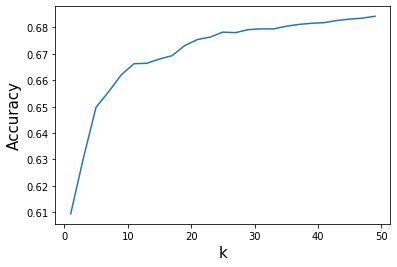

In [36]:
plt.plot(range(1, k_lim, 2), scores)
plt.ylabel("Accuracy", size=15)
plt.xlabel("k", size=15)

In [37]:
i = np.argmax(scores)
print(i*2+1, scores[i])

49 0.6842418021716817


### C. Decision tree and random forest<a name="dtrf"></a>

#### Decision tree

The first thing that strikes out after running tests with different features is that `category` (with label or one-hot encoding) remains the most relevant feature to increase accuracy (about 2% better).

Secondly, we noticed after fitting each single feature separately into a decision tree model is that not only is label encoding much faster than one-hot encoding (just 1 feature vs. many), but it provides similar accuracy. For this reason, most tests combining several features used label encoding. This is interesting because a decision tree might think there is an inherent hierarchy to the label-encoded category, even though that is not the case. It is also worth noting that, when using one-hot encoding, the line across the various levels of depth is more jagged, therefore suggesting that one-hot encoding's effectiveness is more subject to randomness. 

We also noticed that there is no significant difference in performance between the main criteria for picking attributes/thresholds, namely Gini and entropy (the latter seems slightly better).

Generally speaking, adding more features to the decision tree gives more accuracy. Our best results were achieved by keeping all 5 features (with standard or min-max normalization, and label-encoding). That being said, simply combining the `usd_goal_real` (MM) feature with `category` (LE) gave us an accuracy rivaling with the best score. This is consistent with what was observed for logistic regression, thus further increasing our belief that the goal and the category have good synergy, and that increasing the number of features increases accuracy, although the marginal increase of each feature is quite small.

Finally, as expected, normalizing the numerical data doesn't affect accuracy of the decision tree.

In [39]:
scores = []

for d in range(1, 20):
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=RSEED)
    DT.fit(X_train, y_train)
    scores.append(DT.score(X_test, y_test))

scores

[0.6377019069742316,
 0.6377019069742316,
 0.6449543514666954,
 0.645629625628005,
 0.6556101777321592,
 0.6693452541731943,
 0.6721814056506942,
 0.6755982929069202,
 0.6803792339689914,
 0.6810545081303009,
 0.6832829128626222,
 0.6824590783858246,
 0.682702177083896,
 0.683053319647777,
 0.6822429906542056,
 0.6811625519961104,
 0.6796364323915509,
 0.6792447733779915,
 0.6777996866727891]

Text(0.5, 0, 'depth')

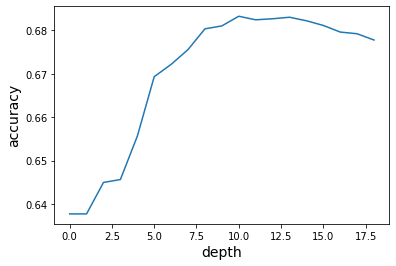

In [40]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('depth', fontsize=14)

In [41]:
i = np.argmax(scores)
print(i+1, scores[i])

11 0.6832829128626222


#### Random forest

Random forests being quite intense in terms of computation, we didn't run all the tests done with decision trees (especially not the ones with one-hot encoding!). 

In [108]:
scores = []

for d in range(1,20):
    RF = RandomForestClassifier(criterion="entropy", n_estimators=100, max_depth=d, random_state=RSEED)
    RF.fit(X_train, y_train)
    scores.append(RF.score(X_test, y_test))

scores

[0.6377019069742316,
 0.6420101561233861,
 0.6590810869212901,
 0.6598238884987305,
 0.6619712603316946,
 0.6640105882988493,
 0.6655232024201826,
 0.671100966992599,
 0.6782588731024796,
 0.6851466695478364,
 0.6904273134892767,
 0.6930743882016098,
 0.6946005078061693,
 0.6973286154178596,
 0.6990168008211334,
 0.6983145156933716,
 0.6988007130895143,
 0.6991923721030738,
 0.6983280211765976]

Text(0.5, 0, 'depth')

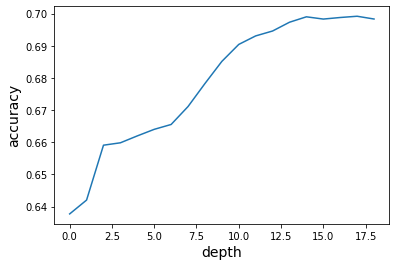

In [109]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('depth', fontsize=14)

In [110]:
i = np.argmax(scores)
print(i+1, scores[i])

18 0.6991923721030738


### D. Neural network<a name="nn"></a>

Highest: 67.12% with cat and maincat
adding country: 66.67

with numerical values it stays low.

all features: 67

In [30]:
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

NN = Sequential()
NN.add(Dense(512, input_shape=(X.shape[1],)))
NN.add(Activation("relu"))
NN.add(Dropout(0.2))
NN.add(Dense(2))
NN.add(Activation("softmax"))

optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
NN.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

NN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               90112     
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_20 (Activation)   (None, 2)                 0         
Total params: 91,138
Trainable params: 91,138
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_hist = NN.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.2)

Train on 236940 samples, validate on 59235 samples
Epoch 1/30
236940/236940 [==============================] - 15s 62us/step - loss: 0.6567 - accuracy: 0.6267 - val_loss: 0.6429 - val_accuracy: 0.6405
Epoch 2/30
236940/236940 [==============================] - 15s 62us/step - loss: 0.6425 - accuracy: 0.6352 - val_loss: 0.6357 - val_accuracy: 0.6405
Epoch 3/30
236940/236940 [==============================] - 14s 61us/step - loss: 0.6364 - accuracy: 0.6356 - val_loss: 0.6305 - val_accuracy: 0.6405
Epoch 4/30
236940/236940 [==============================] - 15s 62us/step - loss: 0.6321 - accuracy: 0.6381 - val_loss: 0.6267 - val_accuracy: 0.6443
Epoch 5/30
236940/236940 [==============================] - 15s 62us/step - loss: 0.6287 - accuracy: 0.6414 - val_loss: 0.6236 - val_accuracy: 0.6512
Epoch 6/30
236940/236940 [==============================] - 14s 61us/step - loss: 0.6262 - accuracy: 0.6448 - val_loss: 0.6213 - val_accuracy: 0.6508
Epoch 7/30
236940/236940 [=======================

### E. Linear regression<a name="linr"></a>

## 4. Conclusion<a name="conclusion"></a>

asd
